In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math
from sklearn.model_selection import KFold


from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *

import learning_utils
import random


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)


now=datetime.datetime.now()

In [2]:
pid = 217
qid = 7966
q = Query.objects.get(pk=qid)
cq = Query.objects.get(pk=7965)
p = Project.objects.get(pk=pid)

docs = Doc.objects.filter(query=cq, content__iregex='\w').values_list('pk', flat=True)

seen = set(DocOwnership.objects.filter(
    query=q, 
    relevant__gt=0
).values_list('doc__pk', flat=True))


seen = seen & set(docs)

seen_docs = Doc.objects.filter(pk__in=seen)
seen_docs.count()

3000

In [3]:
unseen_docs = docs.exclude(pk__in=seen).distinct('id')

unseen_docs.count()

columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(379065, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,1,For improved exploitation of the energy conten...,Proof of concept for a new energy-positive was...,advanced primary treatment; carbon footprint; ...,"[Engineering, Environmental; Environmental Sci...",0,0
1,3,Geological sequestration of pure carbon dioxid...,Wettability determination by contact angle mea...,Contact angle; Wettability; CO2; Sequestration...,"[Chemistry, Physical]",0,0
2,4,"In America, entertainment celebrities have ent...","From sidekick to sideshow - Celebrity, enterta...",politics of distraction; celebrity politics; c...,"[Psychology, Clinical; Social Sciences, Interd...",0,0
3,7,In order to evaluate the effects of pH reducti...,Simulating ocean acidification and CO2 leakage...,CO2-driven acidification; Rank species sensiti...,[Environmental Sciences],0,0
4,10,The degradation of 2-aminoethanol (MEA) by the...,Study of OH-initiated degradation of 2-aminoet...,None,[Meteorology & Atmospheric Sciences],0,0


In [4]:
rated = list(seen_docs.values(*columns))
r_docs = []
for r in rated:
    d = Doc.objects.get(pk=r['id'])

    dos = DocOwnership.objects.filter(
        query__project=p,doc=d,relevant__gt=0,
    ).values_list('relevant',flat=True)
    if not dos.exists():
        dos = DocOwnership.objects.filter(
            project=p,doc=d,relevant__gt=0,
        ).values_list('relevant',flat=True)            
    if len(set(dos))==1: # If there is only one value (all ratings agree)
        if dos[0] == 1:
            r['relevant'] = 1
        elif dos[0] == 2 or dos[0] == 4:
            r['relevant'] = 0
        else:
            continue
        r_docs.append(r)
    
        
seen_df = pd.DataFrame.from_dict(r_docs)
seen_df = seen_df[columns + ["relevant"]]
seen_df['seen'] = 1
print(seen_df.shape)
seen_df.head()

(2968, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,778345,Finding the right balance between centralizati...,Ambitious climate policy through centralizatio...,Centralization; climate policy; decentralizati...,[Environmental Studies; Public Administration],1,1
1,785897,This paper analyzes hybrid emissions trading s...,Combining price and quantity controls under pa...,Emission trading; Hybrid regulation; Partition...,[Economics],1,1
2,437137,Based on qualitative research and a case study...,Triggering Community Conservation Through the ...,community conservation; market-based instrumen...,[Development Studies; Environmental Studies; R...,1,1
3,1307625,Mixed coniferous forests are widespread at mid...,Millennial scale climate-fire-vegetation inter...,Fire history; Vegetation history; Mixed-conife...,"[Geography, Physical; Geosciences, Multidiscip...",1,1
4,196766,Article 2 of the United Nations Framework Conv...,"Dangerous anthropogenic interference, dangerou...",None,[Environmental Sciences; Meteorology & Atmosph...,1,1


In [5]:
df = pd.concat([seen_df,unseen_df]).sample(frac=1).reset_index(drop=True)
y = df['relevant']
df.head()

,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,1827825,The current status and prospects of the world ...,Current state and the future of nuclear energy,nuclear energy; fuel shortage; global warming;...,"[Nuclear Science & Technology; Physics, Nuclea...",0,0
1,641291,P>Aim. This article discusses the clinical imp...,Heatwaves and their impact on people with alco...,clinical policy; comorbidity; heat stress; hea...,[Nursing],0,0
2,705706,The biomarker composition and stable carbon is...,Characterization of n-alkanes and their carbon...,Dianchi watershed; Sediment; n-Alkanes; delta ...,[Environmental Sciences],0,0
3,1841355,Meteorological factors have major impact on cr...,Impact of Growing-Season Meteorology on Japoni...,Meteorology; Japonica rice yield; Model; North...,[Agricultural Economics & Policy; Energy & Fue...,0,0
4,505586,"This study uses a multi-part, split-sample con...",Valuing climate protection through willingness...,Biomass energy; Cellulosic ethanol; Contingent...,[Ecology; Economics; Environmental Sciences; E...,0,0


In [6]:
cats = Category.objects.filter(project=p)
ldf = pd.DataFrame.from_dict(list(seen_docs.filter(
    category__in=cats
).values('id','category__name')))
ldf['v'] = 1

cat_map = ldf.pivot(index='id',columns="category__name", values="v")
cat_map['id'] = cat_map.index
cat_map = cat_map.reset_index(drop=True)

df = pd.merge(df, cat_map, how="left").fillna(0)
print(df.shape)
df.head()

(382033, 52)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen,<hidden>tax/emission trading,Adaptation,Behavioral interventions,...,Spatial & land-use planning,Sub-national/ regional,Subsidies<hidden>,Subsidy/compensation/ allowance,Supranational & international,Targets & goals,Tax,Voluntary actions,Voluntary agreements,voluntary agreement<hidden>
0,1827825,The current status and prospects of the world ...,Current state and the future of nuclear energy,nuclear energy; fuel shortage; global warming;...,"[Nuclear Science & Technology; Physics, Nuclea...",0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,641291,P>Aim. This article discusses the clinical imp...,Heatwaves and their impact on people with alco...,clinical policy; comorbidity; heat stress; hea...,[Nursing],0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,705706,The biomarker composition and stable carbon is...,Characterization of n-alkanes and their carbon...,Dianchi watershed; Sediment; n-Alkanes; delta ...,[Environmental Sciences],0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1841355,Meteorological factors have major impact on cr...,Impact of Growing-Season Meteorology on Japoni...,Meteorology; Japonica rice yield; Model; North...,[Agricultural Economics & Policy; Energy & Fue...,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,505586,"This study uses a multi-part, split-sample con...",Valuing climate protection through willingness...,Biomass energy; Cellulosic ethanol; Contingent...,[Ecology; Economics; Environmental Sciences; E...,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
vec = TfidfVectorizer(
    ngram_range=(1,1),
    min_df=20, max_df=0.8, strip_accents='unicode', 
    max_features=10000,
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=learning_utils.tokenize
)

ab_X = vec.fit_transform(df['content'])

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [11]:
seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

In [8]:
df['mit/ad'] = df['Mitigation'] + df['Adaptation']
print("seen documents:",df.loc[df['seen']==1,].shape[0])
print("seen mitigation documents:", df.loc[df['seen']==1,'Mitigation'].sum())
print("seen adaptation documents", df.loc[df['seen']==1,'Adaptation'].sum())
print("seen mitigation and adaptation documents", df.loc[df['mit/ad']==2,].shape[0])
print("seen non-mit/ad documents",df.loc[(df['seen']==1) & (df['mit/ad']==0),].shape[0])

seen documents: 2968
seen mitigation documents: 2028.0
seen adaptation documents 847.0
seen mitigation and adaptation documents 267
seen non-mit/ad documents 360


In [9]:
classes = ["Mitigation","Adaptation"]
y = np.matrix(df[classes])
y.shape

(382033, 2)

In [12]:
from sklearn.model_selection import KFold
multimodels = [
    {
        'title': 'One vs rest SVC', 
        'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    },
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

for model in multimodels:
    model['e'] = []
    model['i'] = []
    metrics = ['e','p\nboth','r\nboth']
    model['p\nboth'] = []
    model['r\nboth'] = []
    for j, y_class in enumerate(classes):
        model[f'p\n{y_class}'] = []
        model[f'r\n{y_class}'] = []
        metrics += [f'p\n{y_class}', f'r\n{y_class}']

kf = KFold(n_splits=10)
i=0
for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    i+=1
    print(i)
    for model in multimodels:
        clf = model['model']
        model['i'].append(i)
        clf.fit(ab_X[k_train],y[k_train])
        predictions = clf.predict(ab_X[k_test])
        model['e'].append(clf.score(ab_X[k_test],y[k_test]))
        both = y[k_test].sum(axis=1)//2
        both_predictions = predictions.sum(axis=1)//2
        model[f'p\nboth'].append(precision_score(both_predictions, both))
        model[f'r\nboth'].append(recall_score(both_predictions, both))
        for j, y_class in enumerate(classes):
            model[f'p\n{y_class}'].append(precision_score(predictions[:,j],y[k_test,j]))
            model[f'r\n{y_class}'].append(recall_score(predictions[:,j],y[k_test,j]))


1
2
3
4
5
6
7
8
9
10


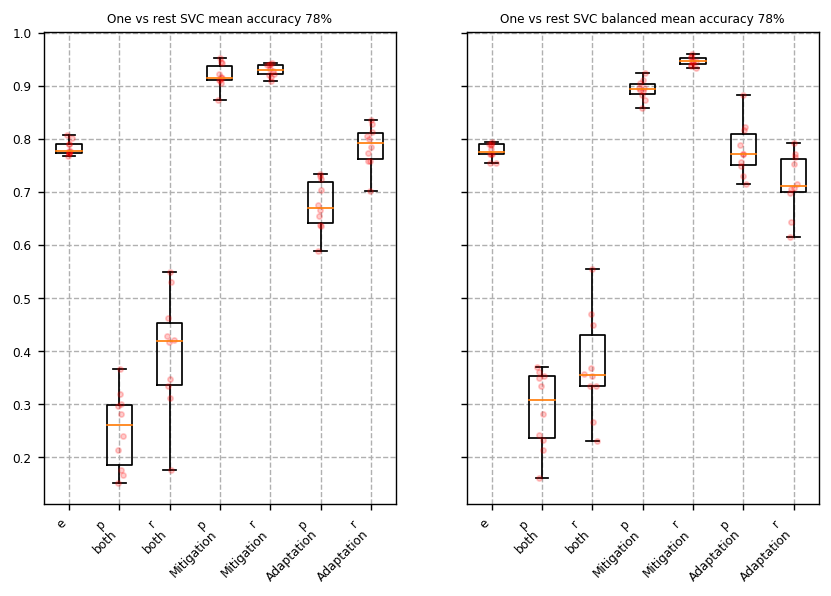

In [13]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(1,len(multimodels),dpi=125,figsize=(8,5),sharey=True)
for i, model in enumerate(multimodels):
    ax = axs[i]
    ax.boxplot([model[x] for x in metrics])
    
    for i,s in enumerate(metrics):
        ys = model[s]
        x = np.random.normal(i+1, 0.04, size=len(ys))
        ax.plot(x, ys, 'r.', alpha=0.2)
    
    ax.set_xticklabels([x for x in metrics], rotation=45, ha="right")
    
    ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
    ax.grid()
    
plt.show()

In [19]:
clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))

clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

In [20]:
y_pred

array([[0.71949362, 0.22454532],
       [0.11624129, 0.94659605],
       [0.24279823, 0.27206747],
       ...,
       [0.00932402, 0.35837196],
       [0.94852391, 0.12312654],
       [0.21095636, 0.75886386]])

131352
379065


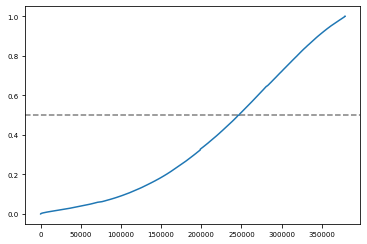

In [21]:
df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])
print(pdf[pdf['prediction'].notna()].shape[0])


In [22]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

tag = Tag(
    title="predicted adaptation sample {}".format(now),
    query=q
)
tag.save()

max_docs = 250
docs_added = 0
topic_added = 0
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    elif d.tag.filter(pk=4728).exists():
        topic_added+=1
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(tag)
            docs_added+=1
        else:
            break  

    
tag.update_tag()

In [23]:
topic_added

13